# Prepare data

In [5]:
# Dataset
# https://download.pytorch.org/tutorial/data.zip
from __future__ import unicode_literals, print_function, division
from io import open
import glob
import os
import unicodedata
import string

all_letters = string.ascii_letters + " .,;'-"
n_letters = len(all_letters) + 1 # Plus EOS marker

def findFiles(path): return glob.glob(path)

# Turn a Unicode string to plain ASCII, thanks to http://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

# Read a file and split into lines
def readLines(filename):
    lines = open(filename, encoding='utf-8').read().strip().split('\n')
    return [unicodeToAscii(line) for line in lines]

# Build the category_lines dictionary, a list of lines per category
category_lines = {}
all_categories = []
for filename in findFiles('data/names/*.txt'):
    category = os.path.splitext(os.path.basename(filename))[0]
    all_categories.append(category)
    lines = readLines(filename)
    category_lines[category] = lines

n_categories = len(all_categories)

if n_categories == 0:
    raise RuntimeError('Data not found. Make sure that you downloaded data '
        'from https://download.pytorch.org/tutorial/data.zip and extract it to '
        'the current directory.')

print('# categories:', n_categories, all_categories)
print(unicodeToAscii("O'Néàl"))

# categories: 18 ['Arabic', 'Chinese', 'Czech', 'Dutch', 'English', 'French', 'German', 'Greek', 'Irish', 'Italian', 'Japanese', 'Korean', 'Polish', 'Portuguese', 'Russian', 'Scottish', 'Spanish', 'Vietnamese']
O'Neal


# Prepare Dataset Input

In [6]:
import torch
import torch.nn as nn

In [7]:
import random

# Random item from a list
def randomChoice(l):
    return l[random.randint(0, len(l) - 1)]

# Get a random category and random line from that category
def randomTrainingPair():
    category = randomChoice(all_categories)
    line = randomChoice(category_lines[category])
    return category, line

In [8]:
# One-hot vector for category
def categoryTensor(category):
    li = all_categories.index(category)
    tensor = torch.zeros(1, n_categories)
    tensor[0][li] = 1
    return tensor

# One-hot matrix of first to last letters (not including EOS) for input
def inputTensor(line):
    tensor = torch.zeros(len(line), 1, n_letters)
    for li in range(len(line)):
        letter = line[li]
        tensor[li][0][all_letters.find(letter)] = 1
    return tensor

# LongTensor of second letter to end (EOS) for target
def targetTensor(line):
    letter_indexes = [all_letters.find(line[li]) for li in range(1, len(line))]
    letter_indexes.append(n_letters - 1) # EOS
    return torch.LongTensor(letter_indexes)

In [9]:
# Make category, input, and target tensors from a random category, line pair
def randomTrainingExample():
    category, line = randomTrainingPair()
    category_tensor = categoryTensor(category)
    input_line_tensor = inputTensor(line)
    target_line_tensor = targetTensor(line)
    return category_tensor, input_line_tensor, target_line_tensor

In [11]:
import time
import math

def timeSince(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [12]:
import torch.nn.utils.rnn as rnn_utils

device = torch.device('cuda:1')

def generate_batch(batch_size=32, device=device):
    """Generate batch input data into device(cpu or cuda)."""
    input_tensors = []
    target_tensors = []
    for _ in range(batch_size):
        category_tensor, input_line_tensor, target_line_tensor = randomTrainingExample()
        category_tensors = torch.stack([category_tensor for _ in range(input_line_tensor.size(0))], 0)
        input_tensor = torch.cat((category_tensors, input_line_tensor), 2).squeeze(1)
        input_tensors.append(input_tensor)
        target_tensors.append(target_line_tensor)
    lengths = [len(i) for i in target_tensors]
    
    # pack data need sort with descending order
    lengths = torch.tensor(lengths).to(device)
    sorted_lengths, ids = lengths.sort(descending=True)

    padded_input_tensors = rnn_utils.pad_sequence(input_tensors, batch_first=True).to(device)
    padded_target_tensors = rnn_utils.pad_sequence(target_tensors, batch_first=True).to(device)
    padded_input_tensors = padded_input_tensors[ids]
    padded_target_tensors = padded_target_tensors[ids]
    
    # pack the sequence
    input_data = rnn_utils.pack_padded_sequence(padded_input_tensors, sorted_lengths, batch_first=True)
    target = rnn_utils.pack_padded_sequence(padded_target_tensors, sorted_lengths, batch_first=True)
    return input_data, target

input_data, target = generate_batch()
print(input_data[0].shape)
print(target[0].shape)

torch.Size([193, 77])
torch.Size([193])


# Create network

In [73]:
import numpy as np
import torch.nn.functional as F

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, device, n_layers=1, bidirectional=False):
        super(LSTMModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.device = device
        self.n_layers = n_layers
        self.n_directions = int(bidirectional) + 1
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers=n_layers, bidirectional=bidirectional)
        self.dropout = nn.Dropout(p=0.1)
        self.linear = nn.Linear(hidden_size, output_size)
                 
    def _init_hidden(self, batch_size):
        h = torch.zeros(self.n_layers*self.n_directions, batch_size, self.hidden_size).to(self.device)
        c = torch.zeros(self.n_layers*self.n_directions, batch_size, self.hidden_size).to(self.device)
        return (h, c)
        
    def forward(self, input_data):
        batch_size = input_data[1][0].item()
        h, c = self._init_hidden(batch_size)
        self.lstm.flatten_parameters()
        output, hidden = self.lstm(input_data, (h, c))
        o = self.linear(self.dropout(output[0]))
        return o
    
    def sample(self, category='Chinese', start_letter='W', max_length=20):
        batch_size = 1
        h, c = self._init_hidden(batch_size)
        category_tensor = categoryTensor(category)
        input_tensor = inputTensor(start_letter)
        category_tensor.unsqueeze_(dim=0)

        output_name = start_letter
        for l in range(max_length):
            input_data = torch.cat((category_tensor, input_tensor), 2).to(self.device)
            output, hidden = rnn.lstm(input_data)
            logits = rnn.linear(output.squeeze(0))
            probs = F.softmax(logits).cpu().detach().numpy()
            next_letter_idx = np.random.choice(n_letters, 1, p=probs[0])[0]
            if next_letter_idx == (n_letters-1):
                return output_name
            letter = all_letters[next_letter_idx]
            output_name += letter
            input_tensor = inputTensor(letter)
        return output_name

rnn = LSTMModel(77, 128, n_letters, device, bidirectional=False).to(device)
output = rnn(input_data)
print(output.shape)

torch.Size([179, 59])


In [41]:
rnn = LSTMModel(77, 128, n_letters, device, bidirectional=False).to(device)
optimizer = torch.optim.Adam(rnn.parameters(), lr=5e-4)
criterion = torch.nn.CrossEntropyLoss()

n_iters = 10000
print_every = 500
plot_every = 50
all_losses = []
total_loss = 0 # Reset every plot_every iters

start = time.time()

for step in range(1, n_iters+1):
    input_data, target = generate_batch()
    input_data = input_data.to(device)
    target = target.to(device)
    output = rnn(input_data)
    loss = criterion(output, target[0])
    total_loss += loss.item()
    loss.backward()
#     optimizer.step()
    for p in rnn.parameters():
        p.data.add_(-5e-4, p.grad.data)
    
    if step % print_every == 0:
        print('%s (%d %d%%) %.4f' % (timeSince(start), step, step / n_iters * 100, loss.item()))

    if step % plot_every == 0:
        all_losses.append(total_loss / plot_every)
        total_loss = 0

0m 3s (500 5%) 3.3610
0m 7s (1000 10%) 3.0293
0m 11s (1500 15%) 2.7329
0m 15s (2000 20%) 2.6086
0m 19s (2500 25%) 2.6355
0m 23s (3000 30%) 2.6084
0m 27s (3500 35%) 2.5290
0m 31s (4000 40%) 2.2579
0m 34s (4500 45%) 2.4001
0m 38s (5000 50%) 2.2273
0m 42s (5500 55%) 2.2597
0m 46s (6000 60%) 2.1635
0m 50s (6500 65%) 2.1767
0m 54s (7000 70%) 2.4054
0m 58s (7500 75%) 2.0846
1m 2s (8000 80%) 2.3101
1m 6s (8500 85%) 2.2102
1m 9s (9000 90%) 2.0667
1m 13s (9500 95%) 1.9666
1m 17s (10000 100%) 1.9207


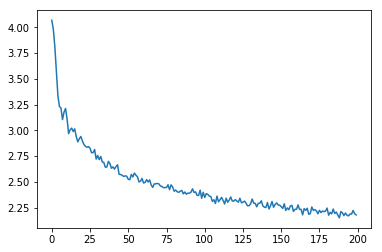

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

plt.figure()
plt.plot(all_losses)
plt.show()

# Sample the network

In [61]:
for country in ['Russian', 'German', 'Spanish' , 'Japanese', 'Chinese']:
    for start_letter in 'SPH':
        print('{}, {}, {}'.format(country, start_letter, rnn.sample(category=country, start_letter=start_letter)))

Russian, S, Sstshoneihaovskoparoi
Russian, P, Palokishinihasstamala
Russian, H, Hovadiaichirowinakoko
German, S, Soriwa
German, P, Pereitrerosseiriturer
German, H, Heroueliersnselierime
Spanish, S, Sonrelepaletiminaleri
Spanish, P, Ponararierevananaonan
Spanish, H, Herinasarisunasuezas
Japanese, S, Shimenayomieriniro
Japanese, P, Purigerohorila
Japanese, H, Hetlalichierinarowao
Chinese, S, Shl
Chinese, P, Pe
Chinese, H, He


/export/home/wangx/code/Siamese/.env/lib/python3.6/site-packages/ipykernel_launcher.py:42: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
